In [21]:
import json
import librosa 
import librosa.display
import numpy as np
import os
from tqdm.notebook import tqdm
import warnings
from audio2numpy import open_audio

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from matplotlib import pyplot as plt

import pickle

warnings.filterwarnings("ignore")


In [3]:
import sys
sys.path.append("../../../")
from utils.segmentation import segment_cough
import sounddevice as sd

In [4]:
# Set dataset path
datasetPath = r".."
rawDataPath = os.path.join(datasetPath, "raw")
outPath = "raw"

In [29]:
with open(os.path.join(datasetPath, "verified_sr_8000.pkl"), "rb") as f:
    data_seg = pickle.load(f)

print("covid: 0, {}".format(np.sum(np.asarray(data_seg["covid"]) == 0)))
print("covid: 1, {}".format(np.sum(np.asarray(data_seg["covid"]) == 1)))

covid: 0, 438
covid: 1, 381


Example

In [15]:
sample_rate = 48000
sample = librosa.resample(data_seg["signal"][0], orig_sr=8000, target_sr=sample_rate)

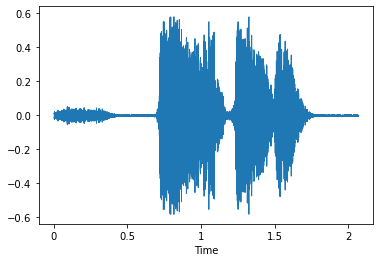

In [20]:
librosa.display.waveshow(y = sample, sr = sample_rate)
sd.play(sample, sample_rate)

Text(0.5, 1.0, 'Segmentation Output')

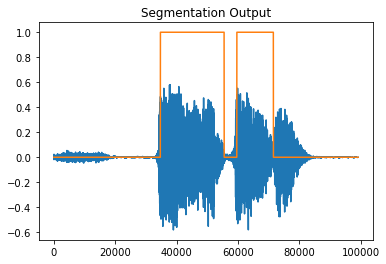

In [22]:
cough_segments, cough_mask = segment_cough(sample, sample_rate, cough_padding=0)

plt.plot(sample)
plt.plot(cough_mask)
plt.title("Segmentation Output")

In [24]:
sd.play(cough_segments[1], sample_rate)

Preprocess

In [34]:
data_seg = {
    "filename": [],
    "signal": [],
    "label": []
}

sample_rate = 48000

for uuid, signal, covid in tqdm(zip(data_seg["filename"], data_seg["signal"], data_seg["covid"]), total = len(data_seg["filename"])):

    signal = librosa.resample(signal, orig_sr=8000, target_sr=sample_rate)

    if signal.size == 0:
        print("Empty audio")
        continue

    cough_segments, cough_mask = segment_cough(signal, sample_rate, cough_padding=0)

    for i, seg in enumerate(cough_segments):
        data_seg["filename"].append(uuid + f"_seg_{i}")
        data_seg["signal"].append(seg)
        data_seg["label"].append(covid)
        break


  0%|          | 0/819 [00:00<?, ?it/s]

In [36]:
print("all:", len(data_seg["signal"]))
print("negative:", sum(np.asarray(data_seg["label"]) == 0))
print("positive:",sum(np.asarray(data_seg["label"]) == 1))

all: 510
negative: 346
positive: 164


In [38]:
with open("segments.pkl", "wb") as f:
    pickle.dump(data_seg, f)

In [39]:
balanced = {
    "filename": [],
    "signal": [],
    "label": []
}

n_pos = sum(np.asarray(data_seg["label"]) == 1)
n_neg = sum(np.asarray(data_seg["label"]) == 0)
choices = np.random.choice(range(n_neg), n_pos, replace = False) + 1

count = 0
for i in range(len(data_seg["filename"])):
    if data_seg["label"][i] == 0:
        count += 1
        if count not in choices:
            continue
    balanced["filename"].append(data_seg["filename"][i])
    balanced["signal"].append(data_seg["signal"][i])
    balanced["label"].append(data_seg["label"][i])

In [40]:
print("all:", len(balanced["signal"]))
print("negative:", sum(np.asarray(balanced["label"]) == 0))
print("positive:",sum(np.asarray(balanced["label"]) == 1))

all: 328
negative: 164
positive: 164


In [41]:
with open("balanced.pkl", "wb") as f:
    pickle.dump(balanced, f)

(array([12., 14., 16., 10., 14., 10., 15., 11.,  9., 17., 11., 11., 15.,
        17., 11.,  7., 11.,  9., 10.,  9.,  9.,  9.,  4.,  3.,  7.,  3.,
         3.,  3.,  4.,  6.,  4.,  1.,  0.,  1.,  4.,  2.,  0.,  4.,  1.,
         1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  1.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.]),
 array([ 9616.  ,  9977.19, 10338.38, 10699.57, 11060.76, 11421.95,
        11783.14, 12144.33, 12505.52, 12866.71, 13227.9 , 13589.09,
        13950.28, 14311.47, 14672.66, 15033.85, 15395.04, 15756.23,
        16117.42, 16478.61, 16839.8 , 17200.99, 17562.18, 17923.37,
        18284.56, 18645.75, 19006.94, 19368.13, 19729.32, 20090.51,
        20451.7 , 20812.89, 21174.08, 21535.27, 21896.46, 22257.65,
        22618.84, 22980.03

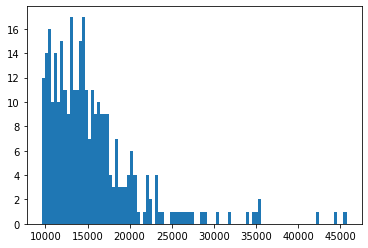

In [42]:
lengths = [len(x) for x in balanced["signal"]]
plt.hist(lengths, 100)

In [43]:
lengths = np.asarray(lengths)
np.sum(lengths < 30720) / len(lengths)

0.9725609756097561

In [44]:
fix_length = 30720
fix_length_signals = [librosa.util.fix_length(x, size = fix_length) for x in balanced["signal"]]

In [45]:
cropped = {
    "filename": balanced["filename"],
    "signal": fix_length_signals,
    "label": balanced["label"]
}

In [48]:
with open("cropped_30720.pkl", "wb") as f:
    pickle.dump(cropped, f)

In [49]:
signals = np.asarray(cropped["signal"])

In [50]:
n_mfcc = 39
frame_length = 2048
hop_length = frame_length // 2
mfccs = librosa.feature.mfcc(y = signals, n_mfcc = n_mfcc, n_fft = frame_length, hop_length = hop_length)
mfccs.shape

(328, 39, 31)

In [51]:
filename = f"mfcc39_fixlength_{fix_length}_nmfcc_{n_mfcc}_framelength_{frame_length}_hoplength_{hop_length}.npy"
np.save(filename, mfccs)